# Imports

In [1]:
from tensorflow.keras.callbacks import TensorBoard, CSVLogger
# from tensorflow.keras.models import load_model
import keras.metrics
from datetime import datetime
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import os
from nmp import model as mod
from nmp import dataset
# from nmp.dataset import pyplot_piano_roll
# from nmp import plotter
from pathlib import Path
import time
import math
# import pypianoroll
# from pypianoroll import Multitrack, Track
# import numpy as np
# import random
# import copy
import tensorflow as tf

Using TensorFlow backend.


# Initialize Variables

In [2]:
D = "data/POP909" # Dataset
# D = "data/Piano-midi.de"  # Dataset
# D = "data/Nottingham"  # Dataset
# D = "data/JSB Chorales"  # Dataset
st = 10  # Past timesteps
num_ts = 10  # Predicted timesteps
BS = 64  # Batch size
EPOCHS = 2  # Number of epochs
DOWN = 1  # Downsampling factor
FS = 24  # Beat resolution: number of timesteps per beat in the piano roll.
LOAD = 0
TRANS = 0
SAVE = 1
KEYBOARD_SIZE = 64  # Number of pitches in the pianoroll.
NOTES = '-' + 'no-down'
# NOTES = '-' + 'ff'

# Do not change.
if KEYBOARD_SIZE == 49:
    LOW_LIM = 36  # C2
    HIGH_LIM = 85  # C6

if KEYBOARD_SIZE == 64:
    LOW_LIM = 33  # A1
    HIGH_LIM = 97  # C7

if KEYBOARD_SIZE == 88:
    LOW_LIM = 21  # A0
    HIGH_LIM = 109  # C8

NUM_NOTES = HIGH_LIM - LOW_LIM
CROP = [LOW_LIM, HIGH_LIM]  # Crop plots
# P = Path(__file__).parent.absolute()
P = Path(os.path.abspath(''))  # Compatible with Jupyter Notebook
PLOTS = P / 'plots'  # Plots path

# TensorFlow stuff
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
from tensorflow.python.client import device_lib
def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]
print(get_available_devices()) 
tf.config.list_physical_devices('GPU')

['/device:CPU:0', '/device:XLA_CPU:0', '/device:GPU:0', '/device:XLA_GPU:0']


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Import MIDI Files

In [4]:
train_list = [x for x in os.listdir(P / D / 'train') if x.endswith('.mid')]
valid_list = [x for x in os.listdir(P / D / 'valid') if x.endswith('.mid')]
test_list = [x for x in os.listdir(P / D / 'test') if x.endswith('.mid')]

train_list = train_list[0:291]
valid_list = valid_list[0:73]
test_list = test_list[0:91]

print("\nTrain list:  ", train_list)
print("\nValidation list:  ", valid_list)
print("\nTest list:  ", test_list)

start = time.time()

train = dataset.Dataset(train_list, P / D / 'train',  fs=FS, bl=0)
validation = dataset.Dataset(valid_list, P / D / 'valid',  fs=FS, bl=0)
test = dataset.Dataset(test_list, P / D / 'test',  fs=FS, bl=0)

train.build_dataset("training", step=st, t_step=num_ts, steps=st,
                    down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
validation.build_dataset("validation", step=st, t_step=num_ts, steps=st,
                         down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)
test.build_dataset("test", step=st, t_step=num_ts, steps=st,
                   down=DOWN, low_lim=LOW_LIM, high_lim=HIGH_LIM)

end = time.time()
print("Done\nLoading time: %.2f" % (end-start))


Train list:   ['504.mid', '605.mid', '158.mid', '385.mid', '613.mid', '758.mid', '641.mid', '598.mid', '034.mid', '800.mid', '714.mid', '334.mid', '615.mid', '415.mid', '612.mid', '680.mid', '284.mid', '091.mid', '126.mid', '010.mid', '817.mid', '901.mid', '090.mid', '905.mid', '395.mid', '609.mid', '314.mid', '272.mid', '630.mid', '182.mid', '595.mid', '174.mid', '547.mid', '084.mid', '391.mid', '221.mid', '856.mid', '132.mid', '259.mid', '349.mid', '839.mid', '871.mid', '016.mid', '105.mid', '278.mid', '848.mid', '517.mid', '486.mid', '563.mid', '233.mid', '752.mid', '274.mid', '607.mid', '762.mid', '008.mid', '318.mid', '532.mid', '139.mid', '313.mid', '573.mid', '383.mid', '343.mid', '874.mid', '290.mid', '264.mid', '157.mid', '390.mid', '470.mid', '840.mid', '577.mid', '454.mid', '412.mid', '592.mid', '491.mid', '757.mid', '121.mid', '097.mid', '053.mid', '421.mid', '776.mid', '647.mid', '803.mid', '778.mid', '894.mid', '210.mid', '779.mid', '388.mid', '628.mid', '171.mid', '689.

# Build the Keras Model

In [5]:
model = mod.build_model((st, NUM_NOTES), (num_ts), NUM_NOTES, BS)
mod.compile_model(model, 'binary_crossentropy', 'adam',
                  metrics=['accuracy',
                           mod.f1,
                           keras.metrics.Precision(),
                           keras.metrics.Recall()])

model.summary()

now = datetime.now()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10, 32)            2080      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                10272     
_________________________________________________________________
Output (Dense)               (None, 640)               21120     
Total params: 33,472
Trainable params: 33,472
Non-trainable params: 0
_________________________________________________________________


# Save Logs

In [6]:
logger = TensorBoard(log_dir=P / 'logs' / now.strftime("%Y%m%d-%H%M%S"),
                     write_graph=True, update_freq='epoch')

csv_logger = CSVLogger(P / 'logs' / (now.strftime("%Y%m%d-%H%M%S") + '-' +
                       str(st) + '-' + str(num_ts) + '.csv'),
                       separator=',', append=False)

# Checkpoints

In [7]:
checkpoint_dir = P / ('models/training_checkpoints/' +
                      now.strftime("%Y%m%d-%H%M%S"))
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                    filepath=checkpoint_prefix,
                    save_weights_only=True,
                    save_best_only=True,
                    period=1)

# Fit the Model (generator)

In [8]:
epochs = EPOCHS
start = time.time()
size_train = math.ceil(train.dataset[0].shape[0] / BS)
spe_train = size_train
size_valid = math.ceil(validation.dataset[0].shape[0] / BS)
spe_valid = size_valid
print("Train dataset shape: ", train.dataset[0].shape, "\n")
print("Train dataset target shape: ", train.dataset[1].shape, "\n")
history = model.fit(dataset.generate((train.dataset[0],
                                      train.dataset[1]),
                    trans=1),
                    epochs=epochs,
                    steps_per_epoch=spe_train,
                    validation_data=dataset.generate((validation.dataset[0],
                                                      validation.dataset[1]
                                                      )),
                    validation_steps=spe_valid,
                    callbacks=[logger, csv_logger, checkpoint_callback])
end = time.time()
print("\nTraining time: ", (end-start), "\n")

hist = pd.DataFrame(history.history)

Train dataset shape:  (2369319, 10, 64) 

Train dataset target shape:  (2369319, 640) 

Train for 37021 steps, validate for 8973 steps
Epoch 1/2
37021/37021 [==============================] - 151s 4ms/step - loss: 0.0859 - accuracy: 0.9703 - f1: 0.7036 - precision_1: 0.7439 - recall_1: 0.5800 - val_loss: 0.0819 - val_accuracy: 0.9716 - val_f1: 0.7338 - val_precision_1: 0.7733 - val_recall_1: 0.6590
Epoch 2/2
37021/37021 [==============================] - 77s 2ms/step - loss: 0.0803 - accuracy: 0.9720 - f1: 0.7309 - precision_1: 0.7749 - recall_1: 0.6698 - val_loss: 0.0811 - val_accuracy: 0.9718 - val_f1: 0.7358 - val_precision_1: 0.7759 - val_recall_1: 0.6762

Training time:  229.5755558013916 



# Evaluation Metrics

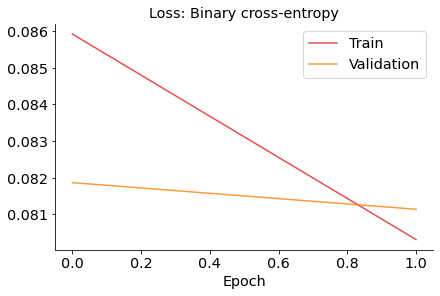

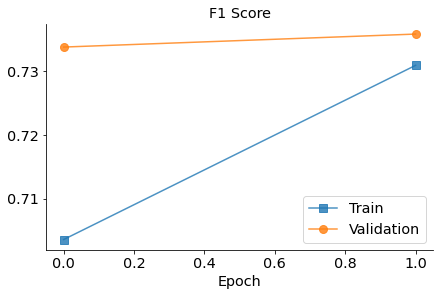

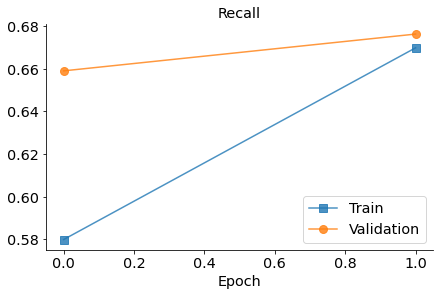

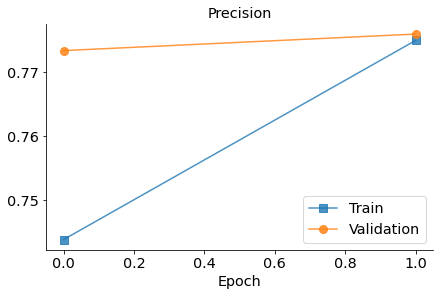

In [9]:
# Loss.
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
plt.plot(hist['loss'], '-', c='tab:red', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_loss'], '-', c='tab:orange', label='Validation', ms=8, alpha=0.8)
plt.xlabel('Epoch', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.title('Loss: Binary cross-entropy', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax = plt.gca()
ax.tick_params(labelsize='x-large')

# F1 score.
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
plt.plot(hist['f1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_f1'], 'o-', c='tab:orange', label='Validation', ms=8,
         alpha=0.8)
plt.xlabel('Epoch', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.title('F1 Score', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax = plt.gca()
ax.tick_params(labelsize='x-large')

# Recall.
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
plt.plot(hist['recall_1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_recall_1'], 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)
plt.xlabel('Epoch', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.title('Recall', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax = plt.gca()
ax.tick_params(labelsize='x-large')

# Precision
fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 4))
plt.plot(hist['precision_1'], 's-', c='tab:blue', label='Train', ms=8, alpha=0.8)
plt.plot(hist['val_precision_1'], 'o-', c='tab:orange', label='Validation', ms=8, alpha=0.8)
plt.xlabel('Epoch', fontsize='x-large')
plt.legend(fontsize='x-large')
plt.title('Precision', fontsize='x-large')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax = plt.gca()
ax.tick_params(labelsize='x-large')

# Save Model

In [14]:
model.save(str(P / 'models' / 'ff-2') + '.h5', save_format='h5')

INFO:tensorflow:Assets written to: /home/cuy/NMP/models/ff-2/assets
